In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels as sm
import os

In [28]:
#read in file
df = pd.read_csv("/Users/hayden2905/Downloads/SO2_EDA_Data.csv")

In [29]:
df.head() #printing just to verify successful read-in

,Month,SO2_Con
0,1/1/15,1.362
1,2/1/15,1.169
2,3/1/15,1.390
3,4/1/15,1.267
4,5/1/15,0.905


In [30]:
df.dtypes #Checking for types

Month       object
SO2_Con    float64
dtype: object

In [31]:
#setting month as index to test for stationarity and build ARIMA model
#df["Month"] = pd.to_datetime(df["Month"]) 

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace = True)


            SO2_Con
Month              
2015-01-01    1.362
2015-02-01    1.169
2015-03-01    1.390
2015-04-01    1.267
2015-05-01    0.905
2015-06-01    1.180
2015-07-01    1.043
2015-08-01    1.149
2015-09-01    1.421
2015-10-01    1.260
2015-11-01    1.262
2015-12-01    1.306
2016-01-01    1.055
2016-02-01    1.494
2016-03-01    1.290
2016-04-01    1.360
2016-05-01    1.120
2016-06-01    1.473
2016-07-01    1.307
2016-08-01    1.208
2016-09-01    1.418
2016-10-01    1.166
2016-11-01    1.175
2016-12-01    1.231
2017-01-01    0.972
2017-02-01    1.202
2017-03-01    1.172
2017-04-01    1.058
2017-05-01    0.916
2017-06-01    1.222
2017-07-01    1.255
2017-08-01    1.289
2017-09-01    1.265
2017-10-01    1.548
2017-11-01    1.230
2017-12-01    1.626
2018-01-01    1.153
2018-02-01    1.266
2018-03-01    1.089
2018-04-01    1.108
2018-05-01    0.991
2018-06-01    1.254
2018-07-01    1.343
2018-08-01    1.207
2018-09-01    1.316
2018-10-01    1.165
2018-11-01    1.389
2018-12-01    0.949


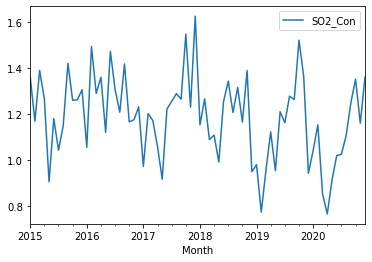

In [32]:
df.head()
df.plot()
pd.set_option('display.max_rows', 72)
print(df)

Using an ADF test to ascertain stationarity

In [35]:
#Doing an Augmented Dickey-Fuller Test to test for stationarity
from pmdarima.arima import ADFTest

In [39]:
test = ADFTest(alpha = 0.05) #significance level 
test.should_diff(df)

(0.01, False)

Output is false, meaning data is not stationary. Need to account for this factor when building model. Now splitting data into test-train data(80-20 split)

In [115]:
#splitting into test and training data
from pmdarima.arima import auto_arima
arima_df = df[["SO2_Con"]]
train_df = arima_df[:58] #80-20 split
test_df = arima_df [-15:]

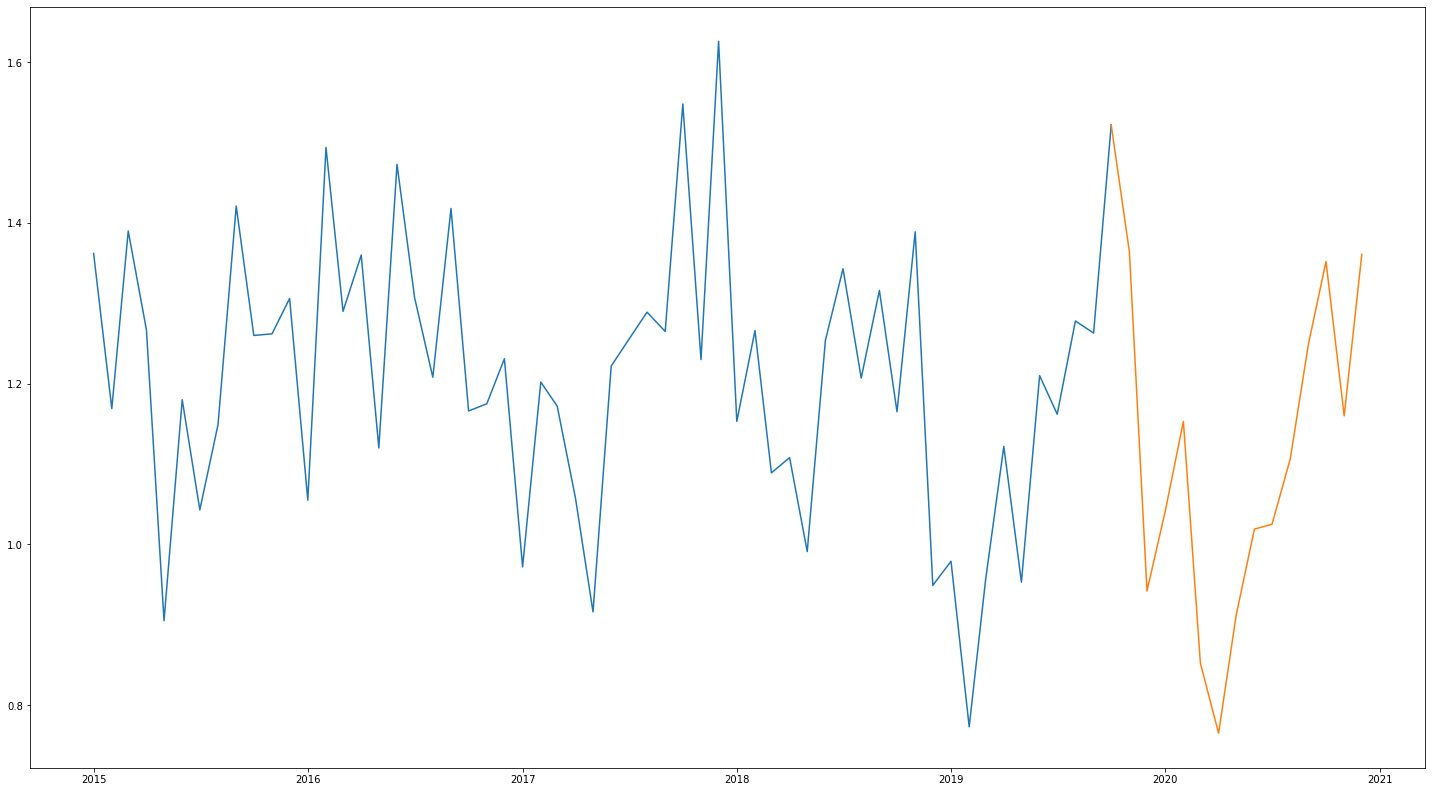

In [116]:
#quick plot of train-test data to verify
fig = plt.figure(figsize = (25,14))
plt.plot(train_df)
plt.plot(test_df)
plt.show()

In [124]:
auto_arima(train_df, start_p=0,start_q=0,
          max_p=10,max_q=5, stationary= False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-36.784, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-37.079, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-36.115, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=189.901, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-42.102, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-40.217, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-40.156, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-37.520, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-41.591, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.881 seconds


ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

Our optimal ARIMA model exists for p = 2, d = 0, q = 0. We will use this model to predict future values. 

In [125]:
#Making predictions with optimized ARIMA model
model = ARIMA(train_df, order = (2,0,0)) 
model_fit= model.fit()
forecast_month= model_fit.predict(start = 58, end = 72)
forecast_df_month = pd.DataFrame(forecast_month)



/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


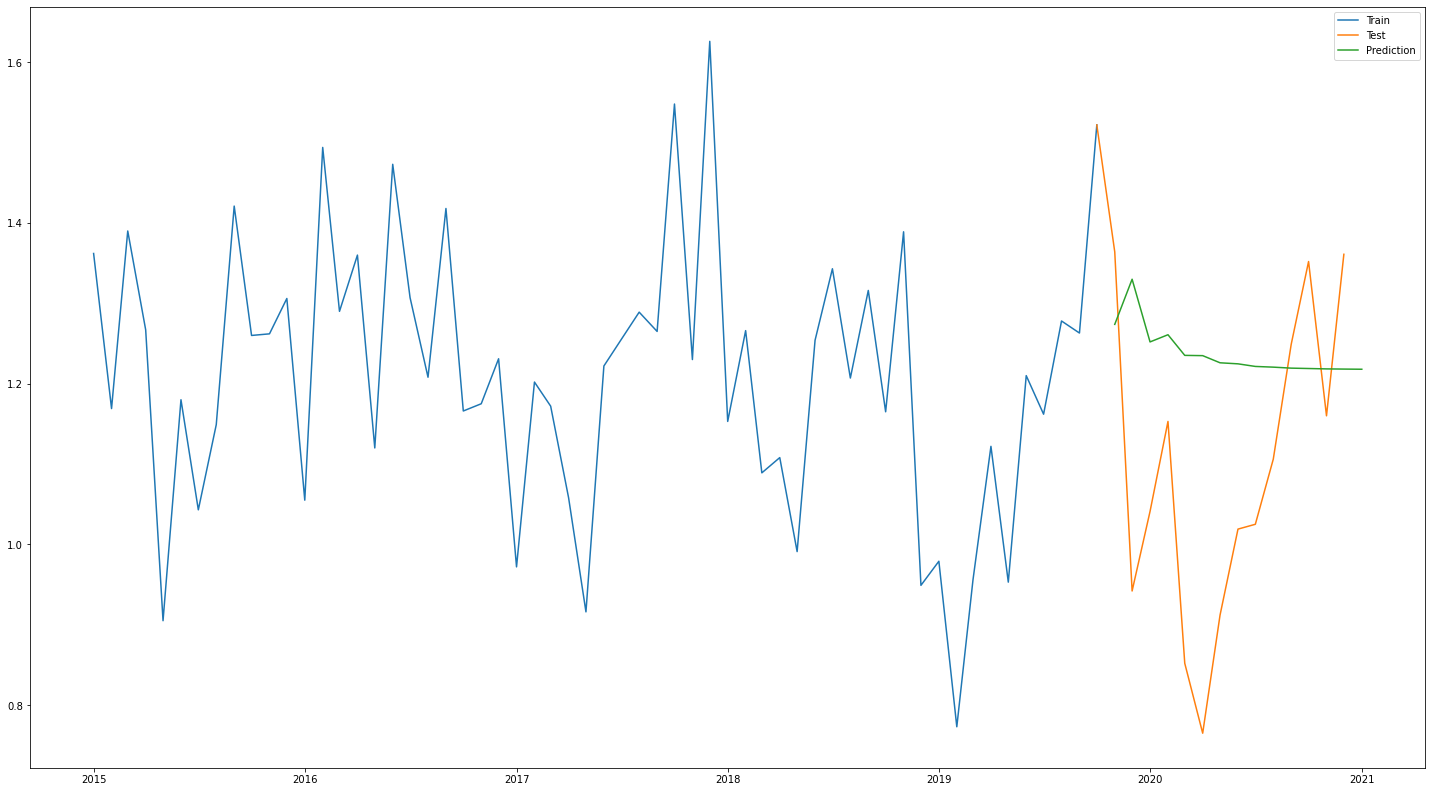

In [126]:
fig = plt.figure(figsize = (25,14))
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_df_month, label='Prediction')
plt.legend()
plt.show()

In [122]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

print(r2_score(test_df, forecast_df_month))
print(sqrt(mean_squared_error(test_df,forecast_df_month))) #MSE

-0.23765558087494876
0.23172770255797046


The correlation coefficient is negative in this scenario, implying that the optimal ARIMA model is a terrible fit. It makes little sense to use such a poor model to forecast future values of SO2 concentrations. Evidently, the SO2 values are more dependent on other hidden variables rather than time itself. A multivariate analysis may be more helpful in predicting SO2 concentration values accurately. 